## Dependencies

In [5]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from copy import deepcopy
import rosbag
import tf
import csv
from tqdm import tqdm
from cv_bridge import CvBridge, CvBridgeError
from std_msgs.msg import Header
from sensor_msgs.msg import Image
from geometry_msgs.msg import PoseWithCovarianceStamped

from generator import GenerateRosbag
from transformations import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
def convert_4x4_matrix_robotics_to_cv(matrix):
    """
    Converts a 4x4 transformation matrix from robotics convention
    (X forward, Y left, Z up) to computer vision convention
    (X right, Y down, Z forward).
    
    Args:
    matrix (np.ndarray): A 4x4 transformation matrix.
    
    Returns:
    np.ndarray: The converted 4x4 transformation matrix.
    """
    # Rotation matrix to convert from robotics to computer vision convention
    R_conversion = np.array([
        [0,  1,  0],
        [1,  0,  0],
        [0,  0, -1]
    ])

    # Extract the 3x3 rotation part and the 3x1 translation part
    R_robotics = matrix[:3, :3]
    t_robotics = matrix[:3, 3]

    # Convert the rotation matrix
    R_cv = R_conversion @ R_robotics

    # Convert the translation vector
    t_cv = R_conversion @ t_robotics

    # Construct the new 4x4 transformation matrix
    matrix_cv = np.eye(4)
    matrix_cv[:3, :3] = R_cv
    matrix_cv[:3, 3] = t_cv

    return matrix_cv


def convert_4x4_matrix_cv_to_robotics(matrix):
    """
    Converts a 4x4 transformation matrix from computer vision convention
    (X right, Y down, Z forward) to robotics convention
    (X forward, Y left, Z up).
    
    Args:
    matrix (np.ndarray): A 4x4 transformation matrix.
    
    Returns:
    np.ndarray: The converted 4x4 transformation matrix.
    """
    # Inverse rotation matrix to convert from computer vision to robotics convention
    R_conversion = np.array([
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, -1]
    ])

    # Extract the 3x3 rotation part and the 3x1 translation part
    R_cv = matrix[:3, :3]
    t_cv = matrix[:3, 3]

    # Convert the rotation matrix
    R_robotics = R_conversion @ R_cv @ R_conversion.T

    # Convert the translation vector
    t_robotics = R_conversion @ t_cv

    # Construct the new 4x4 transformation matrix
    matrix_robotics = np.eye(4)
    matrix_robotics[:3, :3] = R_robotics
    matrix_robotics[:3, 3] = t_robotics

    return matrix_robotics

def rotateZ(matrix, degrees):
    theta = np.radians(degrees)
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    rotation_matrix_z = np.array([
        [cos_theta, -sin_theta, 0, 0],
        [sin_theta, cos_theta, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

    return np.dot(rotation_matrix_z, matrix)

## Read data

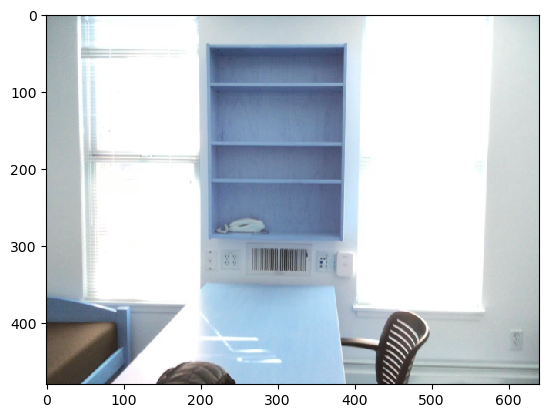

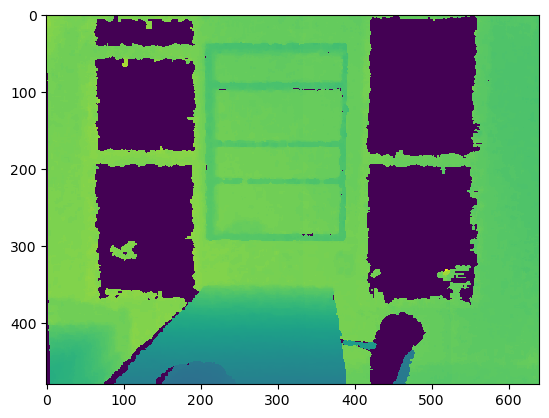

[[ 3.74939946e-33  6.12323400e-17  1.00000000e+00  0.00000000e+00]
 [-1.00000000e+00  6.12323400e-17  0.00000000e+00  0.00000000e+00]
 [-6.12323400e-17 -1.00000000e+00  6.12323400e-17  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 0.888573  0.028642 -0.457841  3.602678]
 [ 0.458533 -0.025727  0.888305  4.083867]
 [ 0.013664 -0.999259 -0.035993  1.4599  ]
 [ 0.        0.        0.        1.      ]]
[[ 0.457841  0.888573 -0.028642  3.602678]
 [-0.888305  0.458533  0.025727  4.083867]
 [ 0.035993  0.013664  0.999259  1.4599  ]
 [ 0.        0.        0.        1.      ]]
[4.060519 3.195562 1.495893]


In [13]:
dataset_path = r"/home/josematez/All_Code/Datasets/ScanNet/raw_data/scene0392_01/"

# Data info
n_data = len(os.listdir(dataset_path + "color/"))

# Depth, RGB, segmentation_img, colors.txt (wall class code), extrinsic.txt (poses), intrinsic.txt (poses), camera_number
with open(dataset_path + "intrinsic/intrinsic_depth.txt", 'r') as file:
    data = file.read()
matrix_list = [list(map(float, row.split())) for row in data.strip().split('\n')]
matrix_array = np.array(matrix_list)
intrinsics = [matrix_array[0, 0], matrix_array[1, 1], matrix_array[0, 2], matrix_array[1, 2]]

n = 1
img_rgb = cv2.imread(dataset_path + "color/" + str(n) + ".jpg", -1)
img_depth = cv2.imread(dataset_path + "depth/" + str(n) + ".png", cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH) / 1000.
img_rgb = cv2.resize(img_rgb, (img_depth.shape[1], img_depth.shape[0]), interpolation=cv2.INTER_AREA)
with open(dataset_path + "pose/" + str(n) + ".txt", 'r') as file:
    data = file.read()
    matrix_list = [list(map(float, row.split())) for row in data.strip().split('\n')]
#pose = convert_4x4_matrix_robotics_to_cv(np.array(matrix_list))
pose =  rotateZ(np.array(matrix_list), 0)

xyz = np.array([0,1,0])
xyz_global = pose[:3,:3] @ xyz + pose[:3,3]

plt.imshow(img_rgb)
plt.show()
plt.imshow(img_depth)
plt.show()

origin, xaxis, yaxis, zaxis = (0, 0, 0), (1, 0, 0), (0, 1, 0), (0, 0, 1)
Rx = rotation_matrix(np.radians(-90), xaxis)
Ry = rotation_matrix(np.radians(90), yaxis)
Rz = rotation_matrix(np.radians(-90), zaxis)

pose_new = pose @ Rz @ Ry
print(Ry@Rz)
print(pose)
print(pose_new)
print(pose_new[:3,:3] @ np.array([1,0,0]) + pose_new[:3,3])





## Create rosbag

  0%|          | 0/2598 [00:00<?, ?it/s]

 51%|█████     | 1330/2598 [01:08<01:07, 18.75it/s]/tmp/ipykernel_3038/1115868395.py:30: RuntimeWarning: invalid value encountered in matmul
  pose = np.array(matrix_list) @ np.linalg.inv(Ry @ Rz)
100%|██████████| 2598/2598 [01:43<00:00, 25.02it/s]


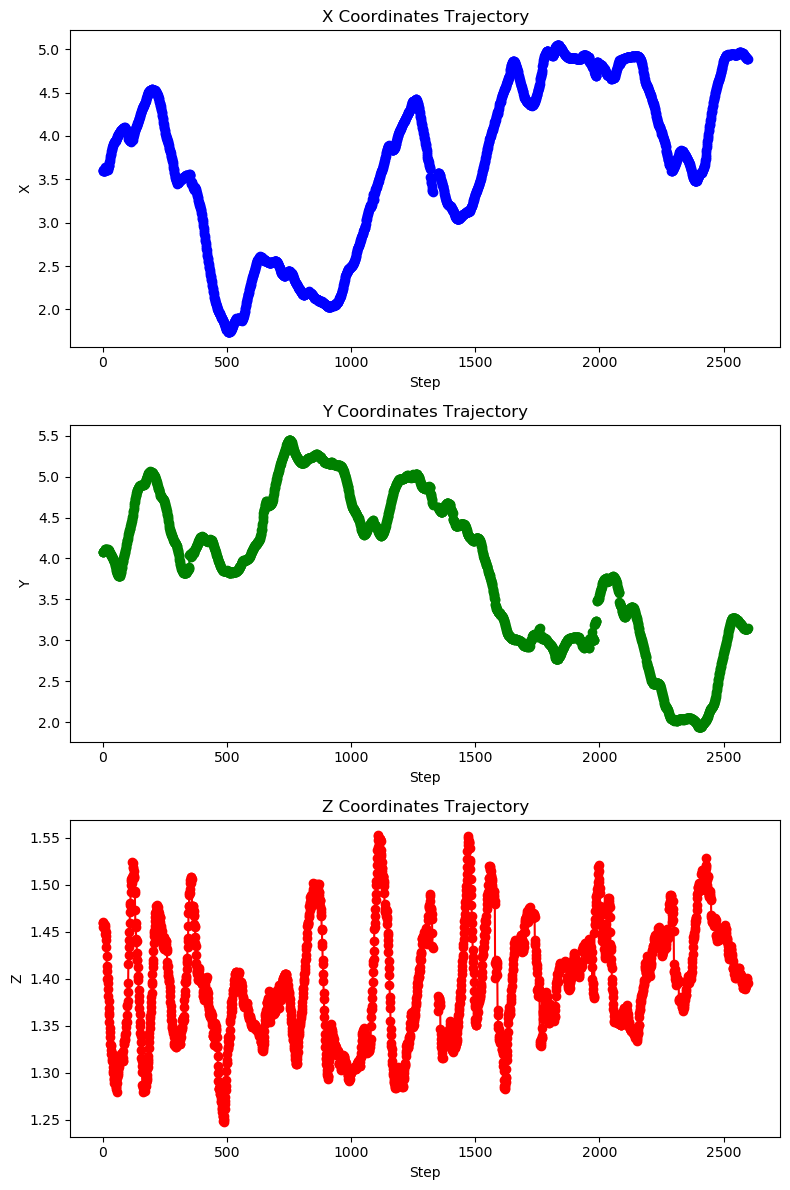

In [14]:
rb = GenerateRosbag()
bag = rosbag.Bag("../ROS1_bags/" + dataset_path.split("/")[-2] + ".bag", "w")

pose_1 = []
pose_2 = []
pose_3 = []

origin, xaxis, yaxis, zaxis = (0, 0, 0), (1, 0, 0), (0, 1, 0), (0, 0, 1)
Rx = rotation_matrix(np.radians(-90), xaxis)
Ry = rotation_matrix(np.radians(90), yaxis)
Rz = rotation_matrix(np.radians(-90), zaxis)

for i in tqdm(range(n_data)):
    
    header = Header()
    header.seq = i
    header.stamp.secs = i
    header.stamp.nsecs = 0
    header.frame_id = "camera"

    img_rgb = cv2.imread(dataset_path + "color/" + str(i) + ".jpg", -1)
    #img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
    img_depth = cv2.imread(dataset_path + "depth/" + str(i) + ".png", cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH) / 1000.
    img_rgb = cv2.resize(img_rgb, (img_depth.shape[1], img_depth.shape[0]), interpolation=cv2.INTER_AREA)
    
    with open(dataset_path + "pose/" + str(i) + ".txt", 'r') as file:
        data = file.read()
        matrix_list = [list(map(float, row.split())) for row in data.strip().split('\n')]
    #pose = convert_4x4_matrix_robotics_to_cv(np.array(matrix_list))
    pose = np.array(matrix_list) @ np.linalg.inv(Ry @ Rz)

    pose_quat = quaternion_from_matrix(pose)
    pose_t = pose[:3,3].reshape(-1)
    pose = [*pose_quat] + [*pose_t]

    pose_1.append(pose_t[0])
    pose_2.append(pose_t[1])
    pose_3.append(pose_t[2])

    rgb_msg = rb.create_image_msg(img_rgb, deepcopy(header))
    depth_msg = rb.create_image_msg(img_depth, deepcopy(header))
    cam_info_msg = rb.create_camera_info_msg(img_rgb, intrinsics, deepcopy(header))
    pose_msg = rb.create_pose_msg(pose, deepcopy(header))
    #tf_msg = rb.create_tf_msg(pose, deepcopy(header))


    bag.write("camera/rgb", rgb_msg)
    bag.write("camera/depth", depth_msg)
    bag.write("camera/camera_info", cam_info_msg)
    #bag.write("tf", tf_msg)
    bag.write("amcl_pose", pose_msg)

bag.close()


fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Plot x coordinates trajectory
axs[0].plot(pose_1, marker='o', linestyle='-', color='b')
axs[0].set_title('X Coordinates Trajectory')
axs[0].set_xlabel('Step')
axs[0].set_ylabel('X')

# Plot y coordinates trajectory
axs[1].plot(pose_2, marker='o', linestyle='-', color='g')
axs[1].set_title('Y Coordinates Trajectory')
axs[1].set_xlabel('Step')
axs[1].set_ylabel('Y')

# Plot z coordinates trajectory
axs[2].plot(pose_3, marker='o', linestyle='-', color='r')
axs[2].set_title('Z Coordinates Trajectory')
axs[2].set_xlabel('Step')
axs[2].set_ylabel('Z')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()